In [509]:
#import packages

# for datafile reading and basic operations
import sqlite3
import pandas as pd
import numpy as np

# for modelling
from scipy.stats import ttest_ind, f_oneway
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn import preprocessing, metrics, preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier

# for visualization
from matplotlib import pyplot as plt
import seaborn as sns

# auxiliary packages
import pickle

### Connection and first insight into the data

In [408]:
# creating connection

cnx = sqlite3.connect('data/viabill.db')

customers = pd.read_sql_query("SELECT * FROM CUSTOMERS", cnx)

transactions = pd.read_sql_query("SELECT * FROM TRANSACTIONS", cnx)

cnx.close()

In [409]:
customers

,customerID,sex,age,residentialAddress,postalAddress,income
0,1,1,25,28 Irvine Place,28 Irvine Place,NaN
1,2,1,19,72 Bertha Street,72 Bertha Street,43200.0
2,3,2,22,63 Ladberry Street,63 Ladberry Street,70200.0
3,4,0,24,98 Linneman Close,98 Linneman Close,93900.0
4,5,1,53,56 Salonica Road,56 Salonica Road,77000.0
...,...,...,...,...,...,...
499995,499996,1,68,95 Argyle Parade,95 Argyle Parade,40500.0
499996,499997,2,22,34 Bearke Place,34 Bearke Place,44900.0
499997,499998,1,27,95 Glenhurst Street,95 Glenhurst Street,48700.0
499998,499999,1,55,34 Kiandra Close,34 Kiandra Close,7600.0


In [410]:
customers.describe(include='all')

,customerID,sex,age,residentialAddress,postalAddress,income
count,500000.000000,500000.000000,500000.000000,500000,500000,490025.000000
unique,NaN,NaN,NaN,396022,389469,NaN
top,NaN,NaN,NaN,43 Boundary Road,,NaN
freq,NaN,NaN,NaN,11,10119,NaN
mean,250000.500000,1.150402,44.630508,NaN,NaN,50000.039182
std,144337.711634,0.477797,16.178283,NaN,NaN,28899.119696
min,1.000000,0.000000,5.000000,NaN,NaN,0.000000
25%,125000.750000,1.000000,27.000000,NaN,NaN,25000.000000
50%,250000.500000,1.000000,50.000000,NaN,NaN,50000.000000
75%,375000.250000,1.000000,58.000000,NaN,NaN,75000.000000


In [411]:
transactions

,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4
0,1,114,2869,140,0,0,0,0
1,2,855,124077,70,0,0,0,0
2,3,752,86184,85,0,0,0,0
3,4,246,248861,43,1,0,0,0
4,5,973,162112,127,0,0,0,0
...,...,...,...,...,...,...,...,...
1999995,1999996,758,333312,12,0,0,1,1
1999996,1999997,932,31802,145,0,2,2,2
1999997,1999998,932,449391,19,0,0,0,0
1999998,1999999,878,433902,198,0,1,0,0


In [412]:
transactions.describe(include='all')

,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4
count,2.000000e+06,2.000000e+06,2000000,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
unique,NaN,NaN,490534,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,20017,NaN,NaN,NaN,NaN,NaN
mean,1.000000e+06,5.492549e+02,NaN,1.015293e+02,1.175885e-01,1.473820e-01,1.895785e-01,2.685700e-01
std,5.773504e+05,2.598474e+02,NaN,5.717575e+01,3.607347e-01,4.278862e-01,5.053638e-01,6.168584e-01
min,1.000000e+00,1.000000e+02,NaN,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000008e+05,3.240000e+02,NaN,5.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+06,5.490000e+02,NaN,1.020000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.500000e+06,7.740000e+02,NaN,1.510000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [413]:
# check if transaction ID is unique in transactions ID

print(len(transactions.transactionID.unique())/len(transactions))

# it is unique - as many transaction IDs as rows in transactions table

1.0


In [414]:
# check if customer ID is unique in transactions ID

print(len(customers.customerID.unique())/len(customers))

# it is unique - as many customer IDs as rows in customers table

1.0


### Task 1

In [415]:
# the last transaction data of each client as credit application data
# sorting values - to be sure we have increasing sequence of transaction IDs
transactions.sort_values('transactionID',inplace=True)

credit_applications=transactions.drop_duplicates(subset='customerID',keep='last')

# join credit_applications data with income from customers table
# one customer has at least one transactions - by the case study description

credit_applications=credit_applications.merge(customers[['customerID','income']],on='customerID',how='left')
credit_applications['income'].fillna(-999,inplace=True)

### Task 2

In [416]:
# task 2, feature engineering: average price of the previous 3 transactions (assuming the current one does not count)

transactions['price_lag1'] = transactions.groupby('customerID')['price'].shift(1)
transactions['price_lag2'] = transactions.groupby('customerID')['price'].shift(2)
transactions['price_lag3'] = transactions.groupby('customerID')['price'].shift(3)
transactions['price_avg_lst3'] = transactions[['price_lag1','price_lag2','price_lag3']].mean(axis=1,skipna=False)

# join with credit_applications

credit_applications=credit_applications.merge(transactions[['transactionID','price_avg_lst3']],on='transactionID',how='left')

### Task 3

In [417]:
# let us check subpopulations of customers with respect to sex variable

print(customers['sex'].value_counts(dropna=False))

# there are three significantly large subsamples divided with respect to sex
# one should perform one way F-ANOVA test to infer about the dependency between age ("continuous") and sex (treated as categorical)
# H0: the mean age in all 3 groups are equal

anova_stat, anova_pvalue = f_oneway(customers[customers['sex']==0]['age'].to_numpy(),
                                    customers[customers['sex']==1]['age'].to_numpy(),
                                    customers[customers['sex']==2]['age'].to_numpy())

alpha=0.05
if (anova_pvalue<alpha):
    print(f'At significance level={alpha}, H1 is accepted - hence, \
          there are differences in average age levels between subpopulations of different sex')
else:
    print(f'At significance level={alpha}, there is no reason to reject H0 \
    saying that average age level is the same between subpopulations of different sex')

# no reason to reject H0 at significance level=0.05

1    374545
2    100328
0     25127
Name: sex, dtype: int64
At significance level=0.05, there is no reason to reject H0     saying that average age level is the same between subpopulations of different sex


### Task 4 - as well as some feature engineering and data analysis/visualization

In [418]:
# let's check if there are any duplicates in the data 

print(sum(customers.duplicated()))
print(sum(transactions.duplicated()))

# no duplicates so we can performe datasets difference operations - to get 'history' data only,
# meaning these transactions which are in transactions table and not in credit_applications table

history=pd.concat([transactions[['transactionID']],
                   credit_applications[['transactionID']]]).drop_duplicates(keep=False)

history=history.merge(transactions,on=['transactionID'],how='inner')

# feature engineering, worst historical status of each installment per customer, worst historical status of any installment,
# number of transactions in the past of a customer

history['worst_paymentstatus1']=history.groupby('customerID')['paytmentStatus1'].transform(max)
history['worst_paymentstatus2']=history.groupby('customerID')['paytmentStatus2'].transform(max)
history['worst_paymentstatus3']=history.groupby('customerID')['paytmentStatus3'].transform(max)
history['worst_paymentstatus4']=history.groupby('customerID')['paytmentStatus4'].transform(max)
history['count']=history.groupby('customerID')['price'].count()
history['worst_paymentstatus_all']=history[['worst_paymentstatus1','worst_paymentstatus2','worst_paymentstatus3',
                                            'worst_paymentstatus4']].max(axis=1)

# joining historical info about a customer with their application profile data

history=history.drop_duplicates(subset='customerID')
credit_applications=credit_applications.merge(history[['customerID','worst_paymentstatus1','worst_paymentstatus2',
                                                       'worst_paymentstatus3','worst_paymentstatus4','worst_paymentstatus_all',
                                                       'count']],on='customerID',how='left')
credit_applications

0
0


,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,income,price_avg_lst3,worst_paymentstatus1,worst_paymentstatus2,worst_paymentstatus3,worst_paymentstatus4,worst_paymentstatus_all,count
0,76,396,330502,49,0,0,0,0,11000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,113,654,44827,152,1,0,0,0,31600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,159,842,113005,5,0,0,0,0,28600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,177,555,239588,174,0,1,0,0,95100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,181,530,485126,194,0,0,0,0,62200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490529,1999996,758,333312,12,0,0,1,1,4200.0,84.000000,0.0,0.0,1.0,1.0,1.0,NaN
490530,1999997,932,31802,145,0,2,2,2,48200.0,117.666667,0.0,0.0,0.0,0.0,0.0,4.0
490531,1999998,932,449391,19,0,0,0,0,100.0,71.000000,2.0,2.0,2.0,2.0,2.0,NaN
490532,1999999,878,433902,198,0,1,0,0,17900.0,114.666667,0.0,0.0,0.0,1.0,1.0,5.0


In [419]:
# null handling 
# for continuous variable like price - mean is to be used
# for count variable - null means nothing - 0
# for worst paymentstatus - -1 is imputed to distinguish a new unknown client from a good client who pays always on time (0)
# there is high number of application with no customer data, so if it is a significant cluster it is going to show up
# but one should consider creating dummy variables on these 'worst_paymentstatus...' vars
# however, it depends on clustering method chosen - k-means here to be used, and we will avoid dummy variables


credit_applications['price_avg_lst3'].fillna(credit_applications['price_avg_lst3'].mean(),inplace=True)
credit_applications['worst_paymentstatus1'].fillna(-1,inplace=True)
credit_applications['worst_paymentstatus2'].fillna(-1,inplace=True)
credit_applications['worst_paymentstatus3'].fillna(-1,inplace=True)
credit_applications['worst_paymentstatus4'].fillna(-1,inplace=True)
credit_applications['worst_paymentstatus_all'].fillna(-1,inplace=True)
credit_applications['count'].fillna(0,inplace=True)

In [420]:
# variables for clustering definition to be chosen

# let us focus on overall worst status and 1st payment status - not to put to much weight on these variables,
# price and price from the previous 3 transactions are informative for changes in behavior
# also frequency of a customer using the product seems to be important

data=credit_applications[['price','worst_paymentstatus_all','worst_paymentstatus1','price_avg_lst3','count']]

# normalize the data for equal treatment of each variable

data_mean=data.mean()
data_std=data.std()
data=(data-data_mean)/(data_std)

1
2
3
4
5
6
7
8
9


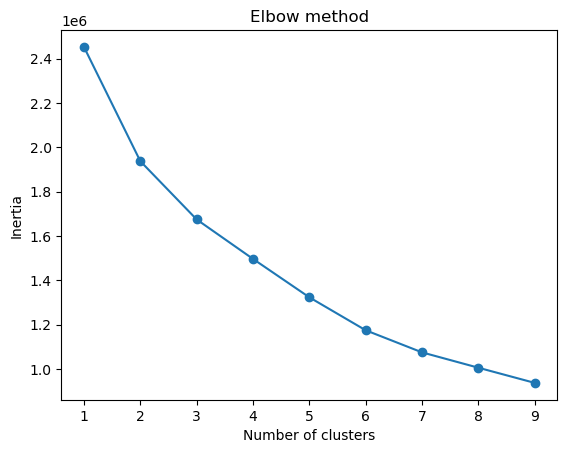

In [421]:
# task 4, marketing customer segmentation

# K-means

data = data.to_numpy()
inertias = []

#let us use the elbow curve for better intuitio

for i in range(1,10):
    kmeans = KMeans(n_clusters=i,random_state=1)
    kmeans.fit(data)
    print(i)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,10), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [422]:
# we are going to use n_clusters=6 

# kmeans = KMeans(n_clusters=n_clusters,random_state=1)
# kmeans.fit(data)

# we will use already serialized model
# load the model

with open(filename_pkl, 'rb') as file:  
    kmeans = pickle.load(file)

# assign clusters to the data, we did not use test dataset as it is not required in unsupervised learning
# also k-means is sufficiently explainable and predictable so one should not expect high instabilities, 
# such a thing could have happened with SOM for example

credit_applications['cluster']=kmeans.predict(data)

#preparing dataset for analysing the differences between clusters and interpret them

clusters_characteristics=pd.DataFrame()

clusters_characteristics['price']=credit_applications.groupby('cluster')['price'].mean().values
clusters_characteristics['price_avg_lst3']=credit_applications.groupby('cluster')['price_avg_lst3'].mean()
clusters_characteristics['worst_paymentstatus1']=credit_applications.groupby('cluster')['worst_paymentstatus1'].mean()
clusters_characteristics['worst_paymentstatus_all']=credit_applications.groupby('cluster')['worst_paymentstatus_all'].mean()
clusters_characteristics['count']=credit_applications.groupby('cluster')['count'].mean()

# let us look into clusters' sizes, all of them are >5%, so they have a significant part of the datase
t
print(credit_applications['cluster'].value_counts(dropna=False)/len(credit_applications))

NameError: name 't' is not defined

In [ ]:
# reference point - observation for the whole dataset indices

clusters_characteristics.loc[len(clusters_characteristics)]=[credit_applications['price'].mean(),
                                                                       credit_applications['price_avg_lst3'].mean(),
                                                                       credit_applications['worst_paymentstatus1'].mean(),
                                                                       credit_applications['worst_paymentstatus_all'].mean(),
                                                                       credit_applications['count'].mean()]

clusters_characteristics['index']=pd.Series(['0','1','2','3','4','5','ALL'])
clusters_characteristics.set_index('index',inplace=True)

print('Average price:')
print(credit_applications['price'].mean())

print('Average price of previous 3 transactions:')
print(credit_applications['price_avg_lst3'].mean())

print('Average worst paymentstatus of the 1st installment:')
print(credit_applications['worst_paymentstatus1'].mean())

print('Average worst paymentstatus in total:')
print(credit_applications['worst_paymentstatus_all'].mean())

print('Average worst paymentstatus in total:')
print(credit_applications['count'].mean())

In [ ]:
clusters_characteristics

In [ ]:
# visualizing distribution of what we see above in the table, we use boxplots to show mean values, interquantile range
# outliers defined as surpassing 95% tails
# we do this with respect to each feature playing role in the clustering and we analyse the differences

for feat in clusters_characteristics.columns:
    fig, axes = plt.subplots(1, 2,figsize=(16,9), gridspec_kw={'width_ratios': [n_clusters, 1]})
    sns.boxplot(ax=axes[0], x = credit_applications['cluster'], y=credit_applications[feat],whis=0.95)
    sns.boxplot(ax=axes[1],y=credit_applications[feat],whis=0.95)
    plt.xlabel('ALL')
    plt.show()

#### Summary of customers clustering results:
- cluster 0: new clients
- cluster 1: high risk clients - often pay late or never pay
- cluster 2: base: low risk clients - 'trinket buyers' subgroup - low transactions, rather pay on time 
- cluster 3: base: low risk clients - 'premium' subgroup - high transactions, rather pay on time
- cluster 4: rising promising customers - they use the product often and increase their transactions' amounts
- cluster 5: loyal buyers - frequently using the product

In [423]:
# serialize the clustering model for future usage

filename_pkl = "models/kmeans_customers_clusters.pkl"  

# save the model
with open(filename_pkl, 'wb') as file:  
    pickle.dump(kmeans, file)

# load the model
# with open(filename_pkl, 'rb') as file:  
#     kmeans = pickle.load(file)

### Task 5 - EDA

In [424]:
customers

# residential adress has no business interpretation without the context - therefore text mining of that is to be skipped

print("Number of nulls - Customers table")
for col in customers.columns:
    print(f'{col} - {sum(customers[col].isna())}')
    
print("Number of nulls - Transactions table")
for col in transactions.columns:
    print(f'{col} - {sum(transactions[col].isna())}')
    
# there have already been some informative transformations involved, but source tables are in good shape
# income nulls only - there was a clear instruction what to do with it



Number of nulls - Customers table
customerID - 0
sex - 0
age - 0
residentialAddress - 0
postalAddress - 0
income - 9975
Number of nulls - Transactions table
transactionID - 0
shopID - 0
customerID - 0
price - 0
paytmentStatus1 - 0
paytmentStatus2 - 0
paytmentStatus3 - 0
paytmentStatus4 - 0
price_lag1 - 490534
price_lag2 - 943480
price_lag3 - 1321627
price_avg_lst3 - 1321627


In [425]:
print("Number of nulls - Transactions table")
for col in credit_applications.columns:
    print(f'{col} - {sum(credit_applications[col].isna())}')

Number of nulls - Transactions table
transactionID - 0
shopID - 0
customerID - 0
price - 0
paytmentStatus1 - 0
paytmentStatus2 - 0
paytmentStatus3 - 0
paytmentStatus4 - 0
income - 0
price_avg_lst3 - 0
worst_paymentstatus1 - 0
worst_paymentstatus2 - 0
worst_paymentstatus3 - 0
worst_paymentstatus4 - 0
worst_paymentstatus_all - 0
count - 0
cluster - 0


In [426]:
# let's explore type of data in our credit application dataset

for feat in credit_applications.columns:
    print(f'{feat} - {credit_applications[feat].dtypes}')
    
# paymentstatus should be reengineered into dummies

transactionID - int64
shopID - int64
customerID - object
price - int64
paytmentStatus1 - int64
paytmentStatus2 - int64
paytmentStatus3 - int64
paytmentStatus4 - int64
income - float64
price_avg_lst3 - float64
worst_paymentstatus1 - float64
worst_paymentstatus2 - float64
worst_paymentstatus3 - float64
worst_paymentstatus4 - float64
worst_paymentstatus_all - float64
count - float64
cluster - int32


In [427]:
def payment_status(x):
    if x==0:
        return 'performing'
    elif x==1:
        return 'late'
    elif x==2:
        return 'default'
    else:
        return 'nodata'

cols_to_transform=['paytmentStatus1', 'paytmentStatus2', 'paytmentStatus3', 'paytmentStatus4','worst_paymentstatus1',
                   'worst_paymentstatus2','worst_paymentstatus3','worst_paymentstatus4','worst_paymentstatus_all']
for col in cols_to_transform:
    credit_applications[f'{col}_str']=credit_applications[f'{col}'].apply(lambda x: payment_status(x))
    
credit_applications.drop(cols_to_transform,axis=1,inplace=True)

In [428]:
# shopID and cluster may be used as well but should be treated as categorical variables as well

credit_applications['shopID']=credit_applications['shopID'].astype(str)
credit_applications['cluster']=credit_applications['cluster'].astype(str)

In [429]:
credit_applications

,transactionID,shopID,customerID,price,income,price_avg_lst3,count,cluster,paytmentStatus1_str,paytmentStatus2_str,paytmentStatus3_str,paytmentStatus4_str,worst_paymentstatus1_str,worst_paymentstatus2_str,worst_paymentstatus3_str,worst_paymentstatus4_str,worst_paymentstatus_all_str
0,76,396,330502,49,11000.0,101.582761,0.0,0,performing,performing,performing,performing,nodata,nodata,nodata,nodata,nodata
1,113,654,44827,152,31600.0,101.582761,0.0,0,late,performing,performing,performing,nodata,nodata,nodata,nodata,nodata
2,159,842,113005,5,28600.0,101.582761,0.0,0,performing,performing,performing,performing,nodata,nodata,nodata,nodata,nodata
3,177,555,239588,174,95100.0,101.582761,0.0,0,performing,late,performing,performing,nodata,nodata,nodata,nodata,nodata
4,181,530,485126,194,62200.0,101.582761,0.0,0,performing,performing,performing,performing,nodata,nodata,nodata,nodata,nodata
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490529,1999996,758,333312,12,4200.0,84.000000,0.0,2,performing,performing,late,late,performing,performing,late,late,late
490530,1999997,932,31802,145,48200.0,117.666667,4.0,5,performing,default,default,default,performing,performing,performing,performing,performing
490531,1999998,932,449391,19,100.0,71.000000,0.0,1,performing,performing,performing,performing,default,default,default,default,default
490532,1999999,878,433902,198,17900.0,114.666667,5.0,5,performing,late,performing,performing,performing,performing,performing,late,late


In [430]:
# let's develop firstly the default flag and then analyse shopIDs to aggregate them with respect to risk level

def default_assign(x):
#     if ((x['paytmentStatus1_str']=='default') or (x['paytmentStatus2_str']=='default') or (x['paytmentStatus3_str']=='default') or (x['paytmentStatus4_str']=='default')):
    if (x['paytmentStatus4_str']=='default'):
        return 1
    else:
        return 0
    
credit_applications['default_flag']=credit_applications.apply(lambda x: default_assign(x),axis=1)

# just checked the assumption - an observation is a default if and only if paytmentStatus4_str=='default'
# simply saying, the data are collected as such that a client cannot have paytmentStatus4_str!='default' if they have paytmentStatus3_str='default'

In [431]:
# bad rate

credit_applications['default_flag'].value_counts(dropna=False)/len(credit_applications)

# >9% which is high enough, there is no reason to include oversampling/undersampling methods

0    0.908008
1    0.091992
Name: default_flag, dtype: float64

In [432]:
# to cluster shopIDs with respect to risk - let's use historical data, in order not to interfer with the training data

# firstly let us define default_flag, we can use paytmentStatus4 only as that assumption already works

def default_flag_assign1(x):
    if x==2:
        return 1
    else:
        return 0

history['default_flag']=history['paytmentStatus4'].apply(lambda x: default_flag_assign1(x))

In [433]:
# let's check the 'count' of each shop ID in the historical data
# but let's take one customer just once - so that bad customer buying in one shope do not bias the results

shops=history[['shopID','default_flag','customerID']]

shops1_onepercustomer=shops.groupby('customerID').agg(np.random.choice)

# let's check the "count" now

x=shops1_onepercustomer.groupby('shopID')['default_flag'].count()
x.describe()

# even the least frequent shop has 426 observations - so they all going to be aggregated in several risk groups

count    900.000000
mean     503.273333
std       22.033819
min      426.000000
25%      488.000000
50%      503.500000
75%      518.000000
max      577.000000
Name: default_flag, dtype: float64

In [434]:
shops_risk=pd.DataFrame(shops1_onepercustomer.groupby('shopID')['default_flag'].mean())
shops_risk.describe()
shops_risk['risk_group_interval']=pd.qcut(shops_risk['default_flag'],3)
print(pd.qcut(shops_risk['default_flag'],5))

# let's divide shops into 3 groups - low_risk, moderate_risk, high_risk shops - they seem significantly different
# let's conduct one-way ANOVA

shops_risk['shopID']=shops_risk.index
shops1=shops.merge(shops_risk[['risk_group_interval']],on='shopID',how='left')
shops1

risk_group_intervals=list(shops_risk['risk_group_interval'].unique())

anova_stat, anova_pvalue = f_oneway(shops1[shops1['risk_group_interval']==risk_group_intervals[0]]['default_flag'].to_numpy(),
                                    shops1[shops1['risk_group_interval']==risk_group_intervals[1]]['default_flag'].to_numpy(),
                                    shops1[shops1['risk_group_interval']==risk_group_intervals[2]]['default_flag'].to_numpy())
print(anova_pvalue)
alpha=0.05
if (anova_pvalue<alpha):
    print(f'At significance level={alpha}, H1 is accepted - hence, there are differences in average default_rate between subpopulations of different shops consumers')
else:
    print(f'At significance level={alpha}, there is no reason to reject H0 saying that average default_rate is the same between subpopulations of different shops consumers')

shopID
100    (0.055099999999999996, 0.0806]
101                  (0.0806, 0.0874]
102                      (0.102, 1.0]
103                      (0.102, 1.0]
104                    (0.094, 0.102]
                    ...              
995    (0.055099999999999996, 0.0806]
996                    (0.094, 0.102]
997                  (0.0806, 0.0874]
998                  (0.0806, 0.0874]
999                   (0.0874, 0.094]
Name: default_flag, Length: 900, dtype: category
Categories (5, interval[float64, right]): [(0.055099999999999996, 0.0806] < (0.0806, 0.0874] < (0.0874, 0.094] < (0.094, 0.102] < (0.102, 1.0]]
1.037701987418953e-190
At significance level=0.05, H1 is accepted - hence, there are differences in average default_rate between subpopulations of different shops consumers


In [435]:
credit_applications.dtypes

transactionID                    int64
shopID                          object
customerID                      object
price                            int64
income                         float64
price_avg_lst3                 float64
count                          float64
cluster                         object
paytmentStatus1_str             object
paytmentStatus2_str             object
paytmentStatus3_str             object
paytmentStatus4_str             object
worst_paymentstatus1_str        object
worst_paymentstatus2_str        object
worst_paymentstatus3_str        object
worst_paymentstatus4_str        object
worst_paymentstatus_all_str     object
default_flag                     int64
dtype: object

In [438]:
# joining shop risk groups in with credit_applications data
shops_risk.drop('shopID',axis=1,inplace=True)
shops_risk.reset_index(inplace=True)
shops_risk['shopID']=shops_risk['shopID'].astype(str)
credit_applications=credit_applications.merge(shops_risk[['shopID','risk_group_interval']],on='shopID',how='left')

In [439]:
risk_group_intervals

[Interval(0.055099999999999996, 0.0852, closed='right'),
 Interval(0.0966, 1.0, closed='right'),
 Interval(0.0852, 0.0966, closed='right')]

In [440]:
# translating shop risk groups into proper names

def shop_risk_group_assign(x):
    if x==risk_group_intervals[0]:
        return 'low_risk_shop'
    elif x==risk_group_intervals[1]:
        return 'high_risk_shop'
    else:
        return 'moderate_risk_shop'
    
credit_applications['shop_risk_group']=credit_applications['risk_group_interval'].apply(lambda x: shop_risk_group_assign(x))

In [448]:
credit_applications.drop('sex',axis=1,inplace=True)

In [449]:
# let's add info about sex to the credit_applications

credit_applications=credit_applications.merge(customers[['customerID','sex']],on='customerID',how='inner')

credit_applications['sex']=credit_applications['sex'].astype(int).astype(str)

In [450]:
print('Default rate (sex: other):')
print(credit_applications[credit_applications['sex']=='0']['default_flag'].mean())
print('Default rate (sex: male):')
print(credit_applications[credit_applications['sex']=='1']['default_flag'].mean())
print('Default rate (sex: female):')
print(credit_applications[credit_applications['sex']=='2']['default_flag'].mean())

Default rate (sex: other):
0.14012635671472543
Default rate (sex: male):
0.07591722080530884
Default rate (sex: female):
0.13990289881569057


In [452]:
anova_stat, anova_pvalue = f_oneway(credit_applications[credit_applications['sex']=='0']['default_flag'].to_numpy(),
                                    credit_applications[credit_applications['sex']=='1']['default_flag'].to_numpy(),
                                    credit_applications[credit_applications['sex']=='2']['default_flag'].to_numpy())

alpha=0.05
if (anova_pvalue<alpha):
    print(f'At significance level={alpha}, H1 is accepted - hence, there are differences in average default rate \
          between subpopulations of different sex')
else:
    print(f'At significance level={alpha}, there is no reason to reject H0 saying that average default rate is the same \
          between subpopulations of different sex')

# as there is a statistical dependence between sensitive data (sex) and risk, I will prepare version of a model without this var
# and there will be challenger applying this var as well

At significance level=0.05, H1 is accepted - hence, there are differences in average default rate between subpopulations of different sex


In [488]:
# selecting final modelling sample data

credit_applications['hist_number_of_transactions']=credit_applications['count']
credit_applications.drop('count', axis=1, inplace=True)
credit_applications['shop_risk_group']=credit_applications['shop_risk_group'].astype(str)

df_all=credit_applications[['transactionID','customerID','price','income','price_avg_lst3','hist_number_of_transactions','cluster','worst_paymentstatus1_str','worst_paymentstatus2_str','worst_paymentstatus3_str','worst_paymentstatus4_str','worst_paymentstatus_all_str','shop_risk_group','default_flag']]

df_all_chall=credit_applications[['transactionID','customerID','price','income','price_avg_lst3','hist_number_of_transactions','cluster','worst_paymentstatus1_str','worst_paymentstatus2_str','worst_paymentstatus3_str','worst_paymentstatus4_str','worst_paymentstatus_all_str','shop_risk_group','default_flag', 'sex']]

In [489]:
df_all.dtypes

transactionID                    int64
customerID                      object
price                            int64
income                         float64
price_avg_lst3                 float64
hist_number_of_transactions    float64
cluster                         object
worst_paymentstatus1_str        object
worst_paymentstatus2_str        object
worst_paymentstatus3_str        object
worst_paymentstatus4_str        object
worst_paymentstatus_all_str     object
shop_risk_group                 object
default_flag                     int64
dtype: object

In [491]:
# for modelling tree-based algorithms are to be used - hence, no need for outliers treatment

# also, multi-collinearity is not a significant issue with ML models - so I skip correlation-based feature elimination

# all categorical variables have been controlled in the run - there are no problems with 
# them having too many/granular unique values

# let us divide variables into numerical and categorical

idvars=['transactionID','customerID']
target='default_flag'

features=list(df_all.columns)
features.remove(target)

for col in idvars:
    features.remove(col)

numFeatures=[]
catFeatures=[]

for i, col in enumerate(features):
    if df_all[col].dtypes=='O':
        catFeatures.append(col)
    if df_all[col].dtypes!='O':
        numFeatures.append(col)


In [492]:
print('Numerical features are:')
print(numFeatures)
print('Categorical features are:')
print(catFeatures)

Numerical features are:
['price', 'income', 'price_avg_lst3', 'hist_number_of_transactions']
Categorical features are:
['cluster', 'worst_paymentstatus1_str', 'worst_paymentstatus2_str', 'worst_paymentstatus3_str', 'worst_paymentstatus4_str', 'worst_paymentstatus_all_str', 'shop_risk_group']


In [493]:
# let's set index to "transactionID" so that after modelling we can identify the observations with that

df_all.set_index('transactionID',inplace=True)

In [495]:
# let us create a test dataset

X_train, X_test, y_train, y_test = train_test_split(
    df_all[features], df_all[target], test_size=0.15, random_state=1, stratify=df_all[target])


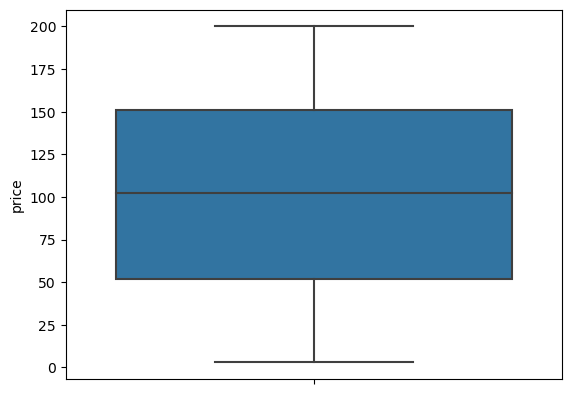

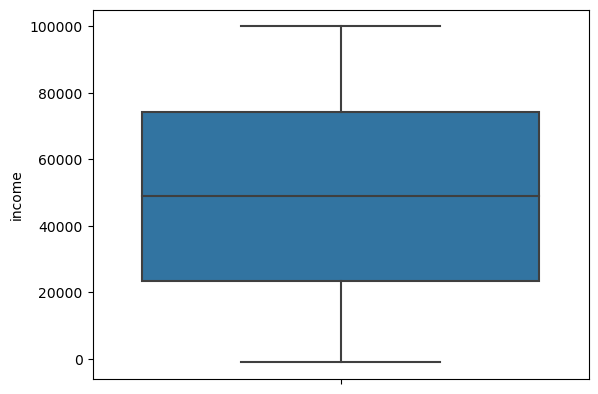

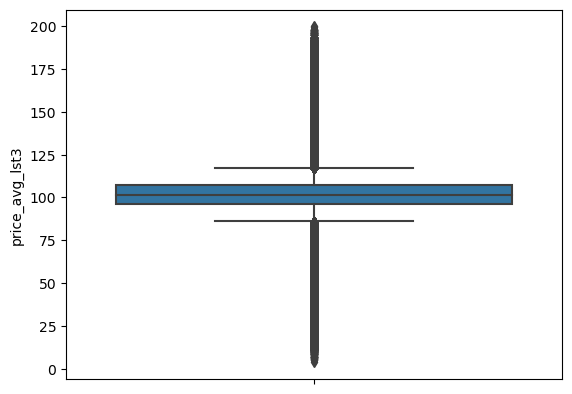

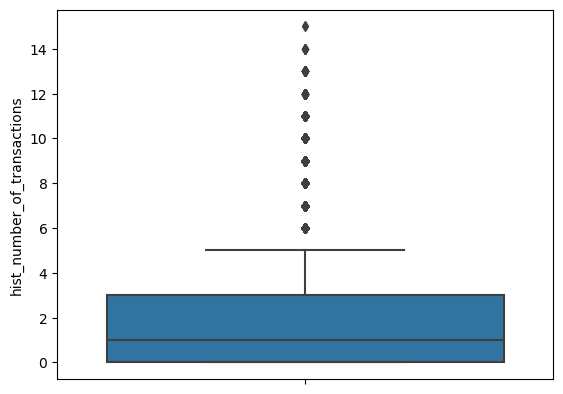

In [496]:
k=0
# figure, axis = plt.subplots(1,7)

for feat in numFeatures:
    sns.boxplot(y=X_train[feat], whis=0.95)
    plt.ylabel(feat)
    plt.show()

In [497]:
# for tree-based algorithms we do not need normalizing the data
# should it be needed, I would calculate moments (mean, std) on training data and save it to development report

# what we still need, is transforming categorical variables to dummies

# we have to make sure that they are in the same sequence in the train and test datasets

dummLev = pd.get_dummies(X_train[catFeatures],drop_first=False)

dummLev_test = pd.get_dummies(X_test[catFeatures],drop_first=False)

for i in dummLev.columns:
    if i not in dummLev_test.columns:
        dummLev_test[i]=0

dummLev_test=dummLev_test[dummLev.columns]

df=pd.concat([X_train[numFeatures],dummLev,y_train],axis=1)

df_test=pd.concat([X_test[numFeatures],dummLev_test,y_test],axis=1)

In [ ]:
# of course, deeper feature engineering could be helpful - ABT for prices (different moving averages, prices relations) etc. 

In [499]:
features=list(df.columns)
features.remove(target)

In [498]:
print(f'Bad rate - {df[target].mean()}')
print(f'Number of observations (training+validation) - {len(df)}')

Bad rate - 0.09199118365858981
Number of observations - 416953


### Task 6 - predictive model

In [517]:
# wrapper for Random Forest Classifier with cross validation

def CV_RF(df = df, nFolds = 5, randomState = 1, features = features, *args, **kwargs):
    kf=KFold(n_splits = nFolds, shuffle = True, random_state = 1)
    
    # results collecting initialized
    valResults=[]
    trainResults=[]
    predictions=[]
    indices=[]
    imp=[]
    
    # loop on all folds for better validation
    for train, val in kf.split(df.index.values):
        
        #RF estimator initialization
        clf = RandomForestClassifier(*args,**kwargs, random_state=1, n_jobs=-1)
        
        # train model
        clf.fit(df.iloc[train][features],df.iloc[train][target])
        
        # prepare test and train predictions
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[val][features])[:,1]
        
        # score standardized
        preds = (preds-min(preds))/(max(preds)-min(preds))
        
        # keep info for this fold's predictions
        predictions.append(preds.tolist().copy())
        
        # keep indices
        indices.append(df.iloc[val].index.tolist().copy())
        
        # AUC calculation
        trainScore = roc_auc_score(df.iloc[train][target], predsTrain)
        valScore = roc_auc_score(df.iloc[val][target], preds)
        
        # saving results in a list
        trainResults.append(trainScore)
        valResults.append(valScore)
        
        # F-score feature importance saved as well
        imp.append(clf.feature_importances_)
        
#         print("Train AUC:", trainScore,
#               "Valid AUC:", valScore)
    
    return trainResults, valResults, predictions, indices, imp

In [518]:
# random search of the best RF classifier model 

results_RF=[]

for i in range(10):

    # hyperparameters setting
    params = {
        "max_depth" : random.randint(5,10),
        "max_features" : random.randint(3,10),
        "min_samples_split" : random.randint(30,400)
    }
    params["min_samples_leaf"] = random.randint(30,params["min_samples_split"])

    # conduct the training
    trainResults, valResults, predictions, indices, imp = CV_RF(n_estimators=100,
                                                               max_depth=params["max_depth"],
                                                               max_features=params["max_features"],
                                                               min_samples_split=params["min_samples_split"],
                                                               min_samples_leaf=params["min_samples_leaf"])
    
    results_RF.append((np.mean(valResults), np.mean(trainResults), np.mean(trainResults)-np.mean(valResults), params.copy()))
    
    print(params, f"MEAN VALIDATION AUC: {round(np.mean(valResults),5)}, MEAN TRAINING AUC: {round(np.mean(trainResults),5)},\
          OVEFITTING: {round(np.mean(trainResults)-np.mean(valResults),5)}")    

Train AUC: 0.6418219377212847 Valid AUC: 0.6061567806317956
Train AUC: 0.6398799973799901 Valid AUC: 0.6090932211455857
Train AUC: 0.6413749053230952 Valid AUC: 0.6070128381788251
Train AUC: 0.6401005161216339 Valid AUC: 0.6122230091837013
Train AUC: 0.6400126064821635 Valid AUC: 0.6045854039326731
{'max_depth': 9, 'max_features': 7, 'min_samples_split': 142, 'min_samples_leaf': 37} MEAN VALIDATION AUC: 0.60781, MEAN TRAINING AUC: (0.64064,),          OVEFITTING: 0.03282
Train AUC: 0.6131528297366189 Valid AUC: 0.6071210318340525
Train AUC: 0.6128094497986215 Valid AUC: 0.6085396740685254
Train AUC: 0.6130335420977898 Valid AUC: 0.6088599761517013
Train AUC: 0.6123332157220888 Valid AUC: 0.612731451420514
Train AUC: 0.6137860868806329 Valid AUC: 0.6042235593604204
{'max_depth': 5, 'max_features': 3, 'min_samples_split': 317, 'min_samples_leaf': 37} MEAN VALIDATION AUC: 0.6083, MEAN TRAINING AUC: (0.61302,),          OVEFITTING: 0.00473
Train AUC: 0.6232244016766025 Valid AUC: 0.6073828

In [541]:
# best validation result

argmax=np.where([i[0] for i in results_RF]==max([i[0] for i in results_RF]))[0][0]
params_opt=[i[3] for i in results_RF][argmax]

clf = RandomForestClassifier(n_estimators=100,max_depth=params["max_depth"],
                             max_features=params["max_features"],min_samples_split=params["min_samples_split"],
                             min_samples_leaf=params["min_samples_leaf"], random_state=1, n_jobs=-1)

clf.fit(df[features],df[target])
        
# prepare test and train predictions
predsTrain = clf.predict_proba(df[features])[:,1]

# AUC calculation
trainScore = roc_auc_score(df[target], predsTrain)

np.mean(trainScore)

0.6207112552053362

In [542]:
# independent test

predsTest = clf.predict_proba(df_test[features])[:,1]

# AUC calculation
testScore = roc_auc_score(df_test[target], predsTest)

np.mean(testScore)

0.6106322344256462

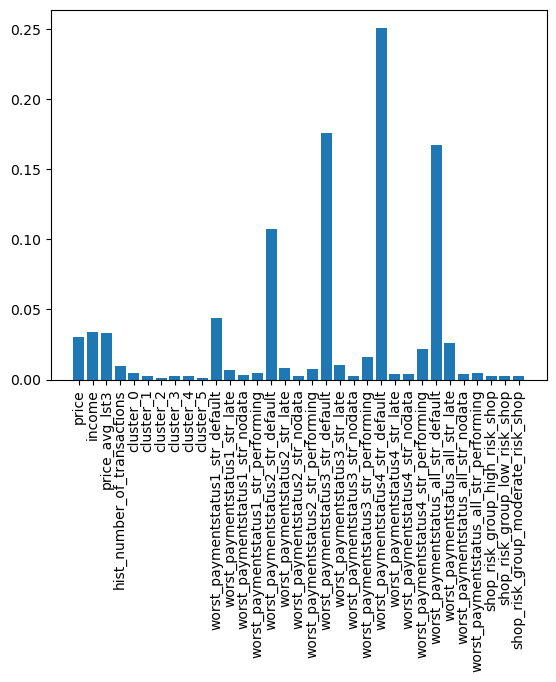

In [559]:
# feature importance, F-score built-in calculation in sklearn
# SHAP to be included

plt.bar(features,np.mean(imp,axis=0))
plt.xticks(rotation=90)
plt.show()

In [ ]:
# XGBoost - to be done

In [525]:
# ROC curve

def plotROC(results):
    ''' Function outputs: a plot with several ROC lines for specific ML models
        Input: results - list of results to draw a ROC line from, each result is a 3 element tuple (true, pred, label)
    '''
    
    fig, ax = plt.subplots(figsize=(10,9))
    
    for true, pred, label in results:
        # calculating points for ROC curve
        # as output we get FPR, TPR and thresholds
        fpr, tpr, thresholds = roc_curve(true, pred)
        
        # AUC
        rocScore = round(roc_auc_score(true,pred),5)
        
        ax.plot(fpr, tpr, lw=2, label = f'{label} AUC: {rocScore}', color='red')
        
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    
    ax.plot([0,1],[0,1], color='blue', lw=2, linestyle='--')
    ax.set_xlim([-0.01,1.0])
    ax.set_ylim([-0.01,1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    plt.show()

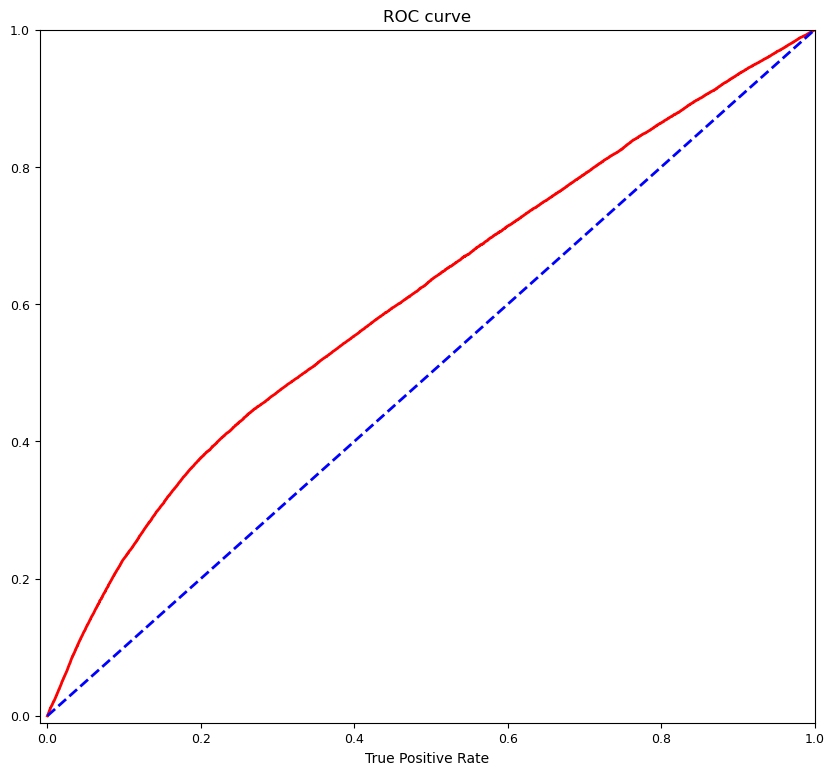

In [526]:
results_plot=[]
pred=pd.Series(sum(predictions,[]), index=sum(indices, [])).sort_index()
true=df[target].sort_index()
results_plot.append((true,pred,'Random Forest'))

plotROC(results_plot)

In [523]:
predictions

[[0.09580132005553504,
  0.09158461559913043,
  0.10659923329377825,
  0.49527617522670925,
  0.12233296785893014,
  0.6446212669533534,
  0.11246132125252173,
  0.1165739961462209,
  0.11113292592790586,
  0.19343036390934518,
  0.1881896664983712,
  0.11793327505178068,
  0.09324380956264472,
  0.11956078808203621,
  0.4922572509582034,
  0.08948226406450538,
  0.10945159341642507,
  0.0764495236148553,
  0.11270180002941661,
  0.11622023840194087,
  0.8469283754662724,
  0.3164374211054339,
  0.06905707464707005,
  0.07057169276146541,
  0.08263170518196787,
  0.8555789011844283,
  0.1786625147412309,
  0.10952200968624136,
  0.24311143765105275,
  0.100833767625724,
  0.35262129545578097,
  0.46044130405570455,
  0.09976361973693212,
  0.2432105156203012,
  0.1108743494295587,
  0.11619242666730986,
  0.10398996305842437,
  0.05515812599584613,
  0.09165417950956256,
  0.10515366338658833,
  0.08594011343249032,
  0.08526091577936777,
  0.4665527826217032,
  0.10659448213323508,
  

In [561]:
# serialize the Random Forest model for future usage

filename_pkl = "models/model_RF.pkl"  

# save the model
with open(filename_pkl, 'wb') as file:  
    pickle.dump(clf, file)

# load the model
# with open(filename_pkl, 'rb') as file:  
#     kmeans = pickle.load(file)

In [ ]:
# .py for models implementation to be done